In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv('school,-sweihan-air-quality.csv', parse_dates=['date'], dayfirst=True)
data.set_index('date', inplace=True)

In [22]:
print("Initial data preview:")
print(data.head())

Initial data preview:
            pm25  pm10  o3  no2  so2
date                                
2024-11-01    89    50  48    5    6
2024-11-02    95    48  50    8    5
2024-11-03   102                    
2024-10-01    68    42  21    4    2
2024-10-02    59    51  35    3    2


In [23]:
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2593 entries, 2024-11-01 to 2016-03-22
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    pm25   275 non-null    float64
 1    pm10   2542 non-null   float64
 2    o3     2370 non-null   float64
 3    no2    2559 non-null   float64
 4    so2    2352 non-null   float64
dtypes: float64(5)
memory usage: 121.5 KB
None


In [24]:
data.columns = data.columns.str.replace(' ', '')
data.columns
data = data.sort_index()

<Figure size 1400x600 with 0 Axes>

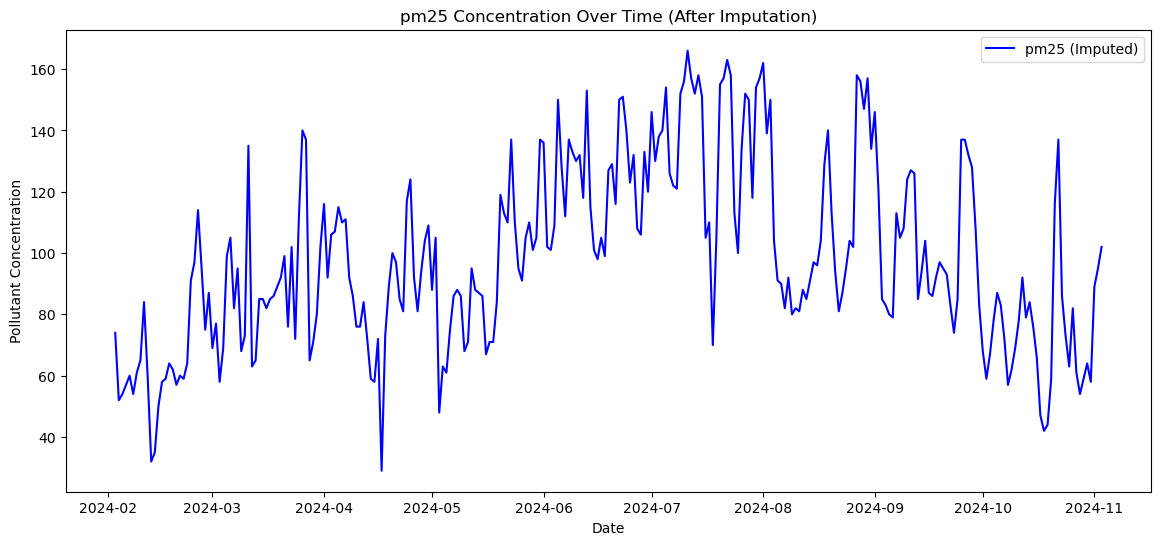

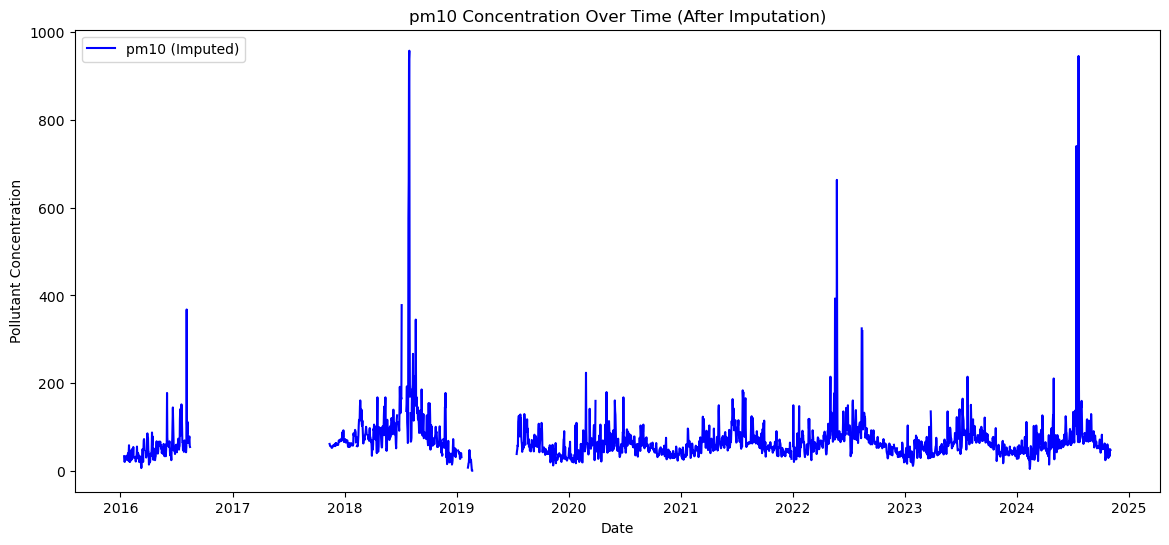

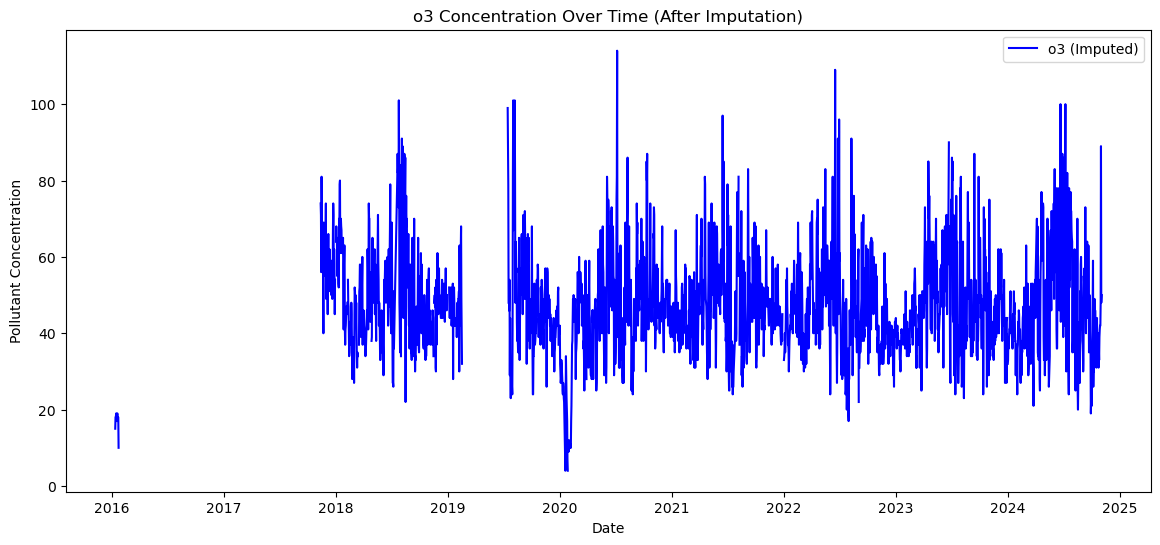

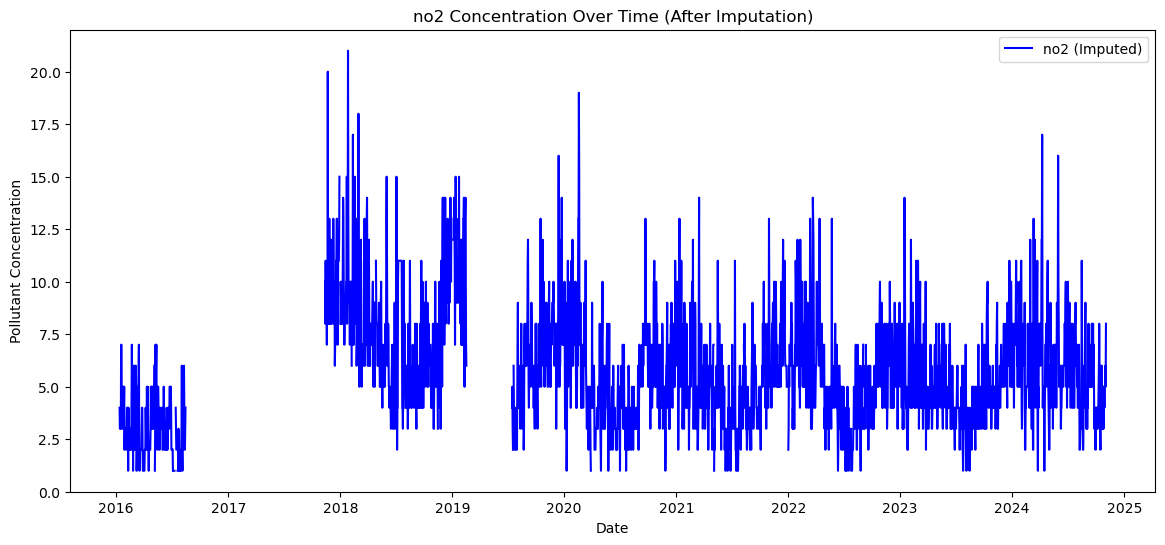

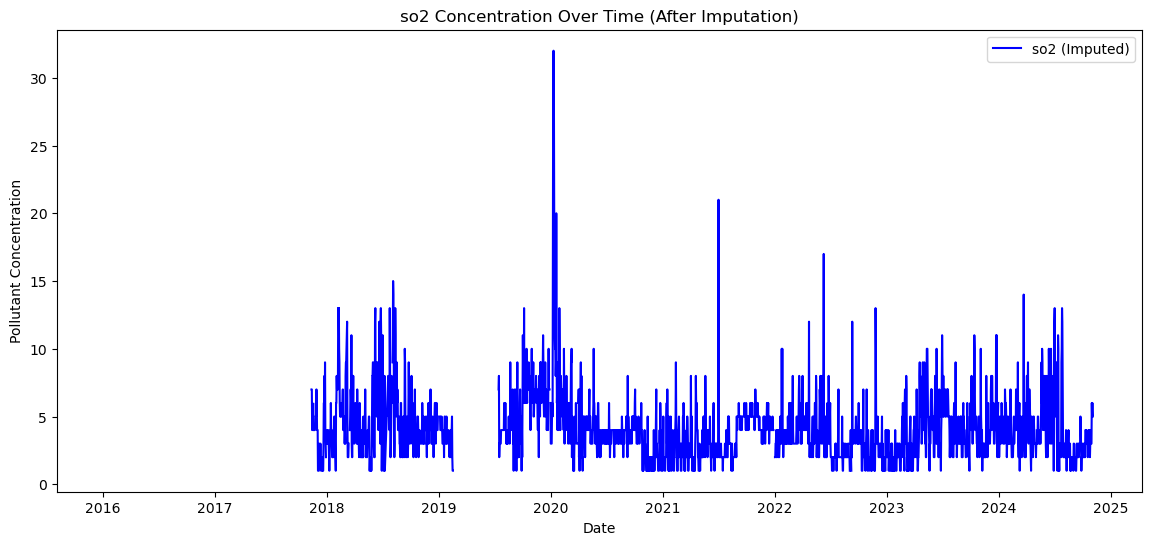

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for column in data.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data[column], label=f'{column} (Imputed)', color='b')
    plt.xlabel('Date')
    plt.ylabel('Pollutant Concentration')
    plt.title(f'{column} Concentration Over Time (After Imputation)')
    plt.legend()
    plt.show()


In [26]:
data_imputed = data.copy()
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)
for column in data.columns:
    non_nan_data = data_imputed[column].interpolate()
    if len(non_nan_data.dropna()) < 2 * 13:  
        print(f"Not enough data for {column} to perform STL decomposition. Skipping...")
        continue
    try:
        stl = STL(non_nan_data, period=13)
        result = stl.fit()
        data[column] = result.trend.fillna(result.seasonal)
    except ValueError as e:
        print(f"STL decomposition failed for {column}: {e}")

<Figure size 1400x600 with 0 Axes>

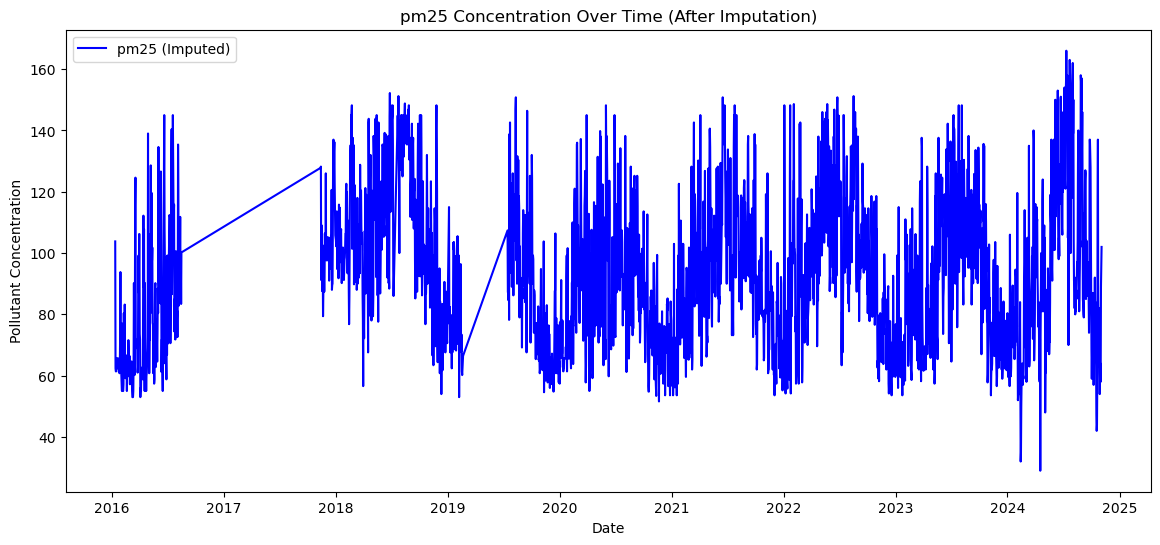

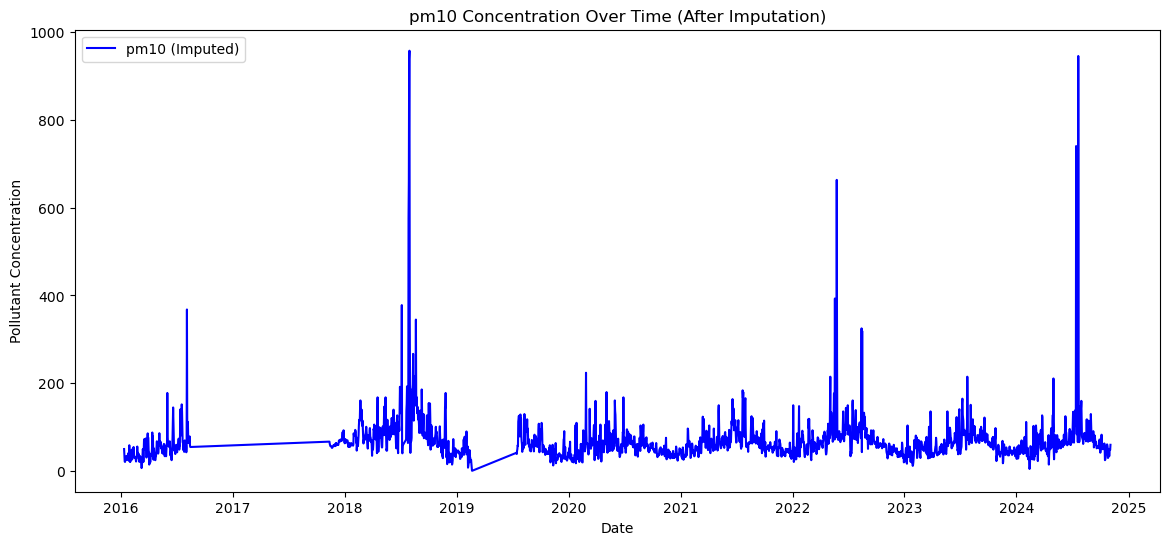

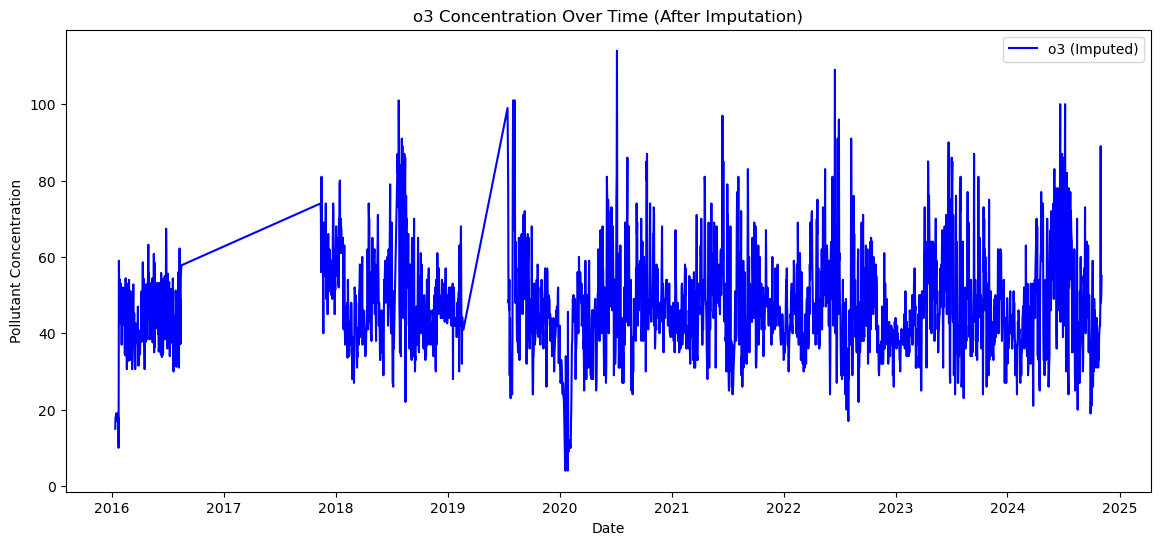

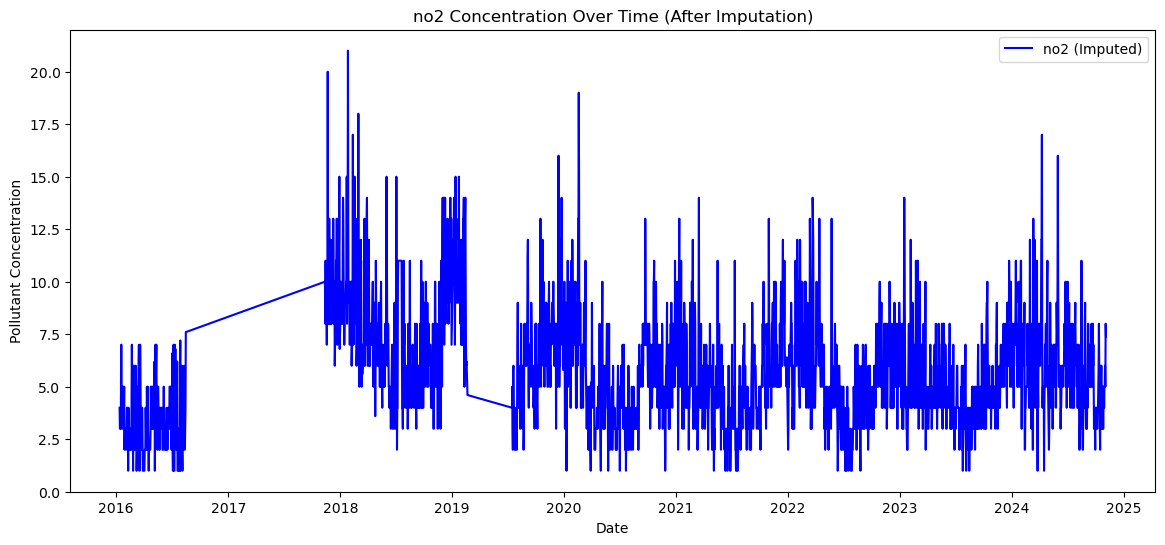

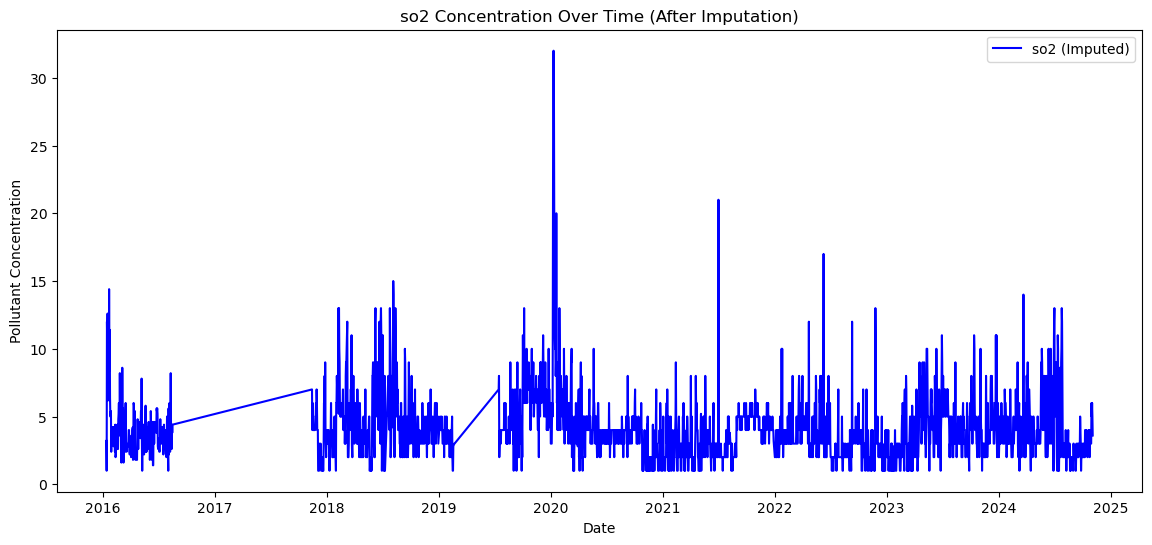

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for column in data_imputed.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(data_imputed.index, data_imputed[column], label=f'{column} (Imputed)', color='b')
    plt.xlabel('Date')
    plt.ylabel('Pollutant Concentration')
    plt.title(f'{column} Concentration Over Time (After Imputation)')
    plt.legend()
    plt.show()


In [28]:
from scipy.signal import savgol_filter

for pollutant in data.columns:
    data_imputed[pollutant] = savgol_filter(data_imputed[pollutant], window_length=15, polyorder=2)

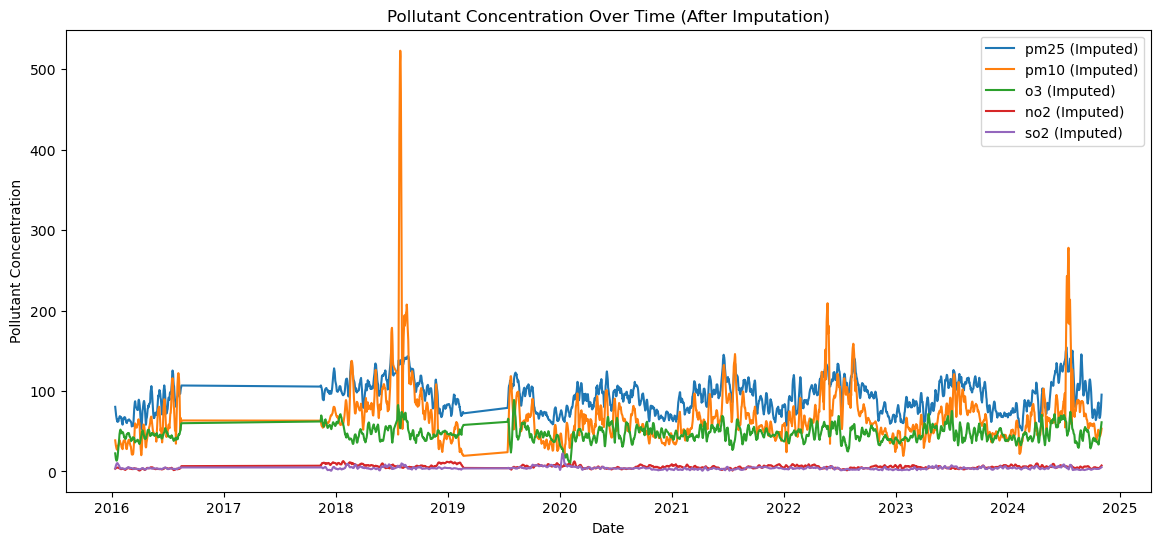

In [29]:
plt.figure(figsize=(14, 6))
for column in data.columns:
    plt.plot(data_imputed.index, data_imputed[column], label=f'{column} (Imputed)')
plt.xlabel('Date')
plt.ylabel('Pollutant Concentration')
plt.title('Pollutant Concentration Over Time (After Imputation)')
plt.legend()
plt.show()

In [30]:
# to prepare data for LSTM model
def prepare_data(series, n_steps):
    X, y = [], []
    for i in range(len(series)):
        end_ix = i + n_steps
        if end_ix > len(series) - 1:
            break
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [31]:
data_imputed.to_csv('processed-school-sweihan.csv', index=True)


In [32]:
scalers = {}
scaled_data = {}
for pollutant in data.columns:
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(data_imputed[[pollutant]])
    scalers[pollutant] = scaler
    scaled_data[pollutant] = scaled_series

In [33]:
scalers

{'pm25': MinMaxScaler(),
 'pm10': MinMaxScaler(),
 'o3': MinMaxScaler(),
 'no2': MinMaxScaler(),
 'so2': MinMaxScaler()}

In [45]:
import joblib

scaler_pm25 = MinMaxScaler().fit(data_imputed[' pm25'].values.reshape(-1, 1))
scaler_o3 = MinMaxScaler().fit(data_imputed[' o3'].values.reshape(-1, 1))

joblib.dump(scaler_pm25, 'scaler_pm25_usembassy.pkl')
joblib.dump(scaler_o3, 'scaler_o3_usembassy.pkl')

['scaler_o3_usembassy.pkl']

In [46]:
scaler = joblib.load('scaler_pm25_usembassy.pkl')
print(type(scaler))

<class 'sklearn.preprocessing._data.MinMaxScaler'>


C:\Users\Durga\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 - 7s - 107ms/step - loss: 0.0317 - val_loss: 0.0128
Epoch 2/50
64/64 - 2s - 25ms/step - loss: 0.0085 - val_loss: 0.0096
Epoch 3/50
64/64 - 2s - 25ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 4/50
64/64 - 2s - 29ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 5/50
64/64 - 2s - 25ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 6/50
64/64 - 2s - 28ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 7/50
64/64 - 1s - 23ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 8/50
64/64 - 2s - 27ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/50
64/64 - 2s - 28ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/50
64/64 - 2s - 27ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 11/50
64/64 - 2s - 27ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 12/50
64/64 - 2s - 26ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 13/50
64/64 - 1s - 23ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 14/50
64/64 - 2s - 24ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 15/50
64/64 - 2s - 26ms/step - loss:

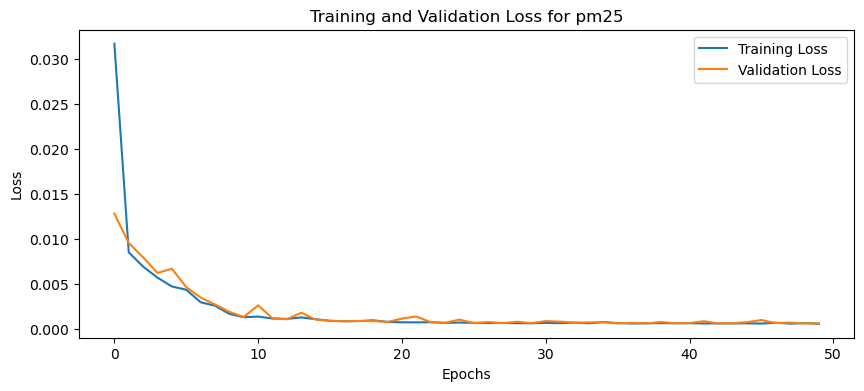

Epoch 1/50
64/64 - 8s - 118ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 2/50
64/64 - 1s - 22ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 3/50
64/64 - 2s - 26ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/50
64/64 - 2s - 25ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/50
64/64 - 2s - 33ms/step - loss: 0.0015 - val_loss: 9.4657e-04
Epoch 6/50
64/64 - 2s - 28ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/50
64/64 - 2s - 29ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/50
64/64 - 2s - 28ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/50
64/64 - 2s - 27ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 10/50
64/64 - 2s - 30ms/step - loss: 0.0013 - val_loss: 9.3331e-04
Epoch 11/50
64/64 - 2s - 29ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/50
64/64 - 2s - 25ms/step - loss: 0.0012 - val_loss: 8.2086e-04
Epoch 13/50
64/64 - 2s - 35ms/step - loss: 0.0011 - val_loss: 8.0949e-04
Epoch 14/50
64/64 - 2s - 26ms/step - loss: 0.0011 - val_loss: 7.2301e-04
Epoch 15/50
64/64 - 1s

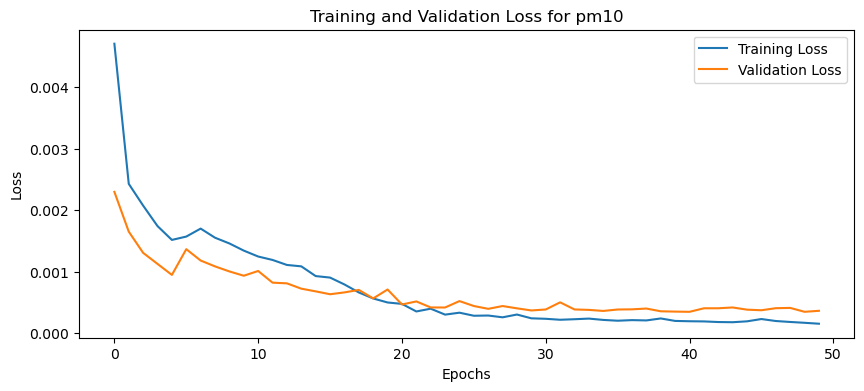

Epoch 1/50
64/64 - 7s - 109ms/step - loss: 0.0508 - val_loss: 0.0117
Epoch 2/50
64/64 - 3s - 43ms/step - loss: 0.0085 - val_loss: 0.0092
Epoch 3/50
64/64 - 1s - 22ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 4/50
64/64 - 1s - 23ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 5/50
64/64 - 2s - 31ms/step - loss: 0.0075 - val_loss: 0.0102
Epoch 6/50
64/64 - 2s - 35ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/50
64/64 - 2s - 31ms/step - loss: 0.0048 - val_loss: 0.0062
Epoch 8/50
64/64 - 3s - 51ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 9/50
64/64 - 2s - 31ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 10/50
64/64 - 2s - 33ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 11/50
64/64 - 2s - 38ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 12/50
64/64 - 2s - 36ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 13/50
64/64 - 3s - 39ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 14/50
64/64 - 2s - 32ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 15/50
64/64 - 2s - 35ms/step - loss:

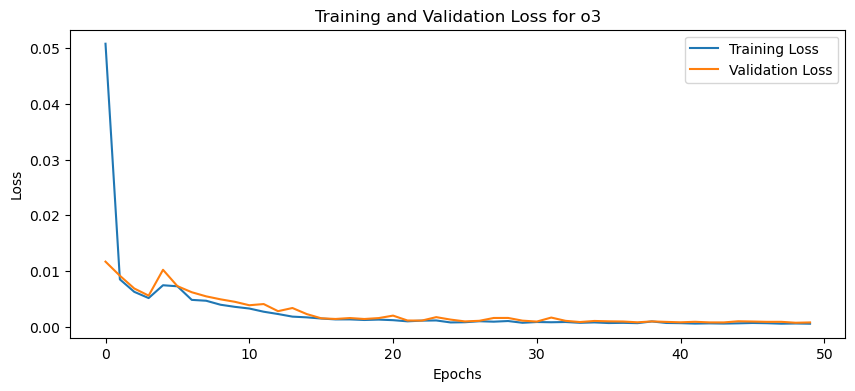

Epoch 1/50
64/64 - 7s - 117ms/step - loss: 0.0312 - val_loss: 0.0074
Epoch 2/50
64/64 - 2s - 28ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 3/50
64/64 - 2s - 27ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 4/50
64/64 - 2s - 26ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 5/50
64/64 - 2s - 25ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 6/50
64/64 - 2s - 28ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 7/50
64/64 - 2s - 34ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 8/50
64/64 - 2s - 33ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 9/50
64/64 - 2s - 25ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 10/50
64/64 - 2s - 34ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/50
64/64 - 2s - 30ms/step - loss: 0.0014 - val_loss: 9.3727e-04
Epoch 12/50
64/64 - 2s - 25ms/step - loss: 0.0013 - val_loss: 9.5560e-04
Epoch 13/50
64/64 - 2s - 38ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 14/50
64/64 - 2s - 36ms/step - loss: 0.0016 - val_loss: 9.2881e-04
Epoch 15/50
64/64 - 3s - 41ms/

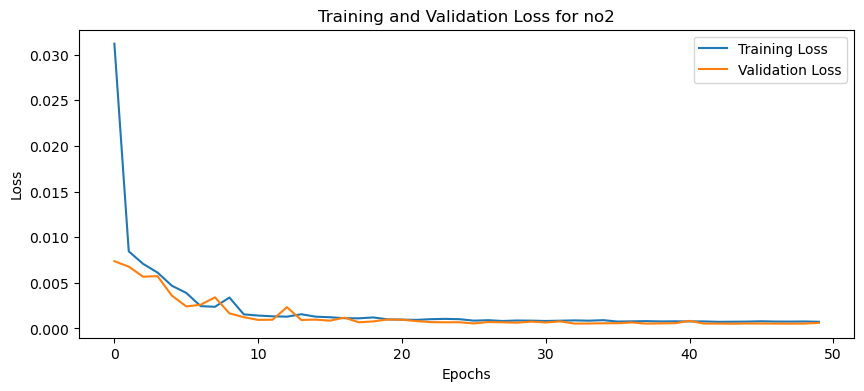

Epoch 1/50
64/64 - 7s - 111ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 2/50
64/64 - 2s - 27ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 3/50
64/64 - 2s - 32ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/50
64/64 - 2s - 28ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 5/50
64/64 - 2s - 26ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 6/50
64/64 - 1s - 22ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/50
64/64 - 2s - 27ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/50
64/64 - 2s - 29ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/50
64/64 - 2s - 24ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/50
64/64 - 2s - 31ms/step - loss: 0.0011 - val_loss: 9.8058e-04
Epoch 11/50
64/64 - 2s - 27ms/step - loss: 0.0010 - val_loss: 9.1832e-04
Epoch 12/50
64/64 - 2s - 31ms/step - loss: 8.4644e-04 - val_loss: 6.5926e-04
Epoch 13/50
64/64 - 1s - 17ms/step - loss: 7.3739e-04 - val_loss: 8.9077e-04
Epoch 14/50
64/64 - 1s - 16ms/step - loss: 6.2923e-04 - val_loss: 4.9618e-04
Epoch 15/5

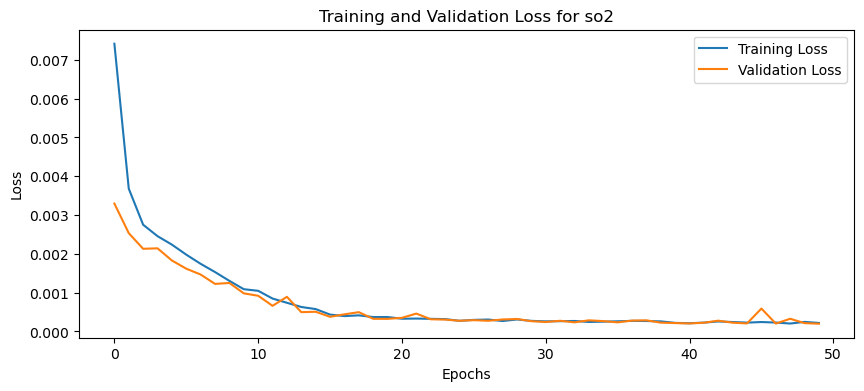

In [34]:
train_size = 0.8  # 80% training, 20% validation
train_data = {}
val_data = {}

for pollutant in data.columns:
    series_length = len(scaled_data[pollutant])
    train_end = int(train_size * series_length)
    train_data[pollutant], val_data[pollutant] = scaled_data[pollutant][:train_end], scaled_data[pollutant][train_end - 30:]  # Include a buffer for validation sequence

models = {}
histories = {}
n_steps = 30  # Number of past days for prediction

for pollutant in data.columns:
    X_train, y_train = prepare_data(train_data[pollutant], n_steps)
    X_val, y_val = prepare_data(val_data[pollutant], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build Bi-LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)
    models[pollutant] = model
    histories[pollutant] = history

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {pollutant}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [35]:
future_steps = 7  # Number of days to predict
predictions = {}

for pollutant, model in models.items():
    pollutant_name = pollutant
    input_seq = scaled_data[pollutant_name][-n_steps:].reshape(1, n_steps, 1)
    predicted_values = []
    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        predicted_values.append(pred[0][0])
        pred_reshaped = pred.reshape(1, 1, 1)
        input_seq = np.append(input_seq[:, 1:, :], pred_reshaped, axis=1)  # Slide the window
    predictions[pollutant] = scalers[pollutant_name].inverse_transform(np.array(predicted_values).reshape(-1, 1))

aqi_forecast = np.max([predictions[pollutant] for pollutant in predictions], axis=0)

dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=future_steps)
prediction_df = pd.DataFrame(aqi_forecast, index=dates, columns=['Predicted AQI'])

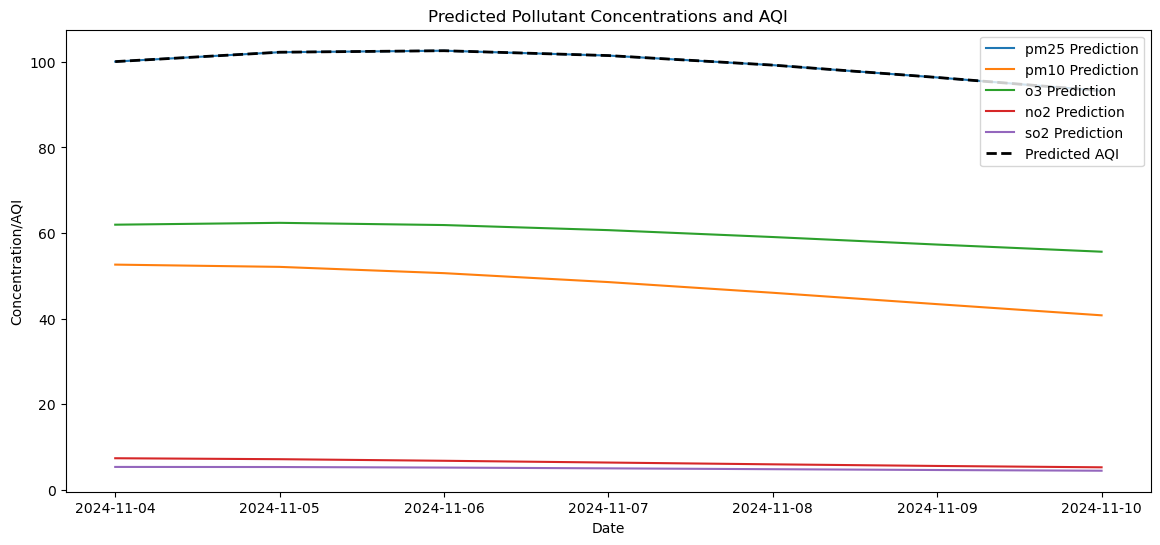

Predicted AQI for the next 7 days:
            Predicted AQI
2024-11-04     100.050110
2024-11-05     102.243614
2024-11-06     102.591515
2024-11-07     101.460640
2024-11-08      99.229607
2024-11-09      96.345779
2024-11-10      93.227310


In [36]:
plt.figure(figsize=(14, 6))
for pollutant in predictions:
    plt.plot(dates, predictions[pollutant], label=f'{pollutant} Prediction')
plt.plot(dates, aqi_forecast, 'k--', label='Predicted AQI', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Concentration/AQI')
plt.title('Predicted Pollutant Concentrations and AQI')
plt.legend()
plt.show()

print("Predicted AQI for the next 7 days:")
print(prediction_df)


In [37]:
models

{'pm25': <Sequential name=sequential, built=True>,
 'pm10': <Sequential name=sequential_1, built=True>,
 'o3': <Sequential name=sequential_2, built=True>,
 'no2': <Sequential name=sequential_3, built=True>,
 'so2': <Sequential name=sequential_4, built=True>}

In [38]:
for model_name, model in models.items():
    model.save(f'{model_name}_school-sweihan_trainedmodel.keras')

In [39]:
predictions

{'pm25': array([[100.05011 ],
        [102.243614],
        [102.591515],
        [101.46064 ],
        [ 99.22961 ],
        [ 96.34578 ],
        [ 93.22731 ]], dtype=float32),
 'pm10': array([[52.623714],
        [52.096325],
        [50.629173],
        [48.54414 ],
        [46.04636 ],
        [43.38976 ],
        [40.7778  ]], dtype=float32),
 'o3': array([[61.950916],
        [62.38487 ],
        [61.867275],
        [60.67818 ],
        [59.068687],
        [57.307293],
        [55.63914 ]], dtype=float32),
 'no2': array([[7.392329 ],
        [7.16803  ],
        [6.799383 ],
        [6.383993 ],
        [5.968261 ],
        [5.5904574],
        [5.2717853]], dtype=float32),
 'so2': array([[5.36063  ],
        [5.3402066],
        [5.2102695],
        [5.0295672],
        [4.8311663],
        [4.640496 ],
        [4.4757204]], dtype=float32)}